<a href="https://colab.research.google.com/github/as9786/ComputerVision/blob/main/ImageSegmentation/code/UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get OxfordDataset

In [ ]:
import os
import re
import random
import xml.etree.ElementTree as et
from PIL import Image 

import cv2
import numpy as np
import tensorflow as tf 
from tensorflow import keras

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
from matplotlib.patches import Rectangle

In [ ]:
import gdown

# google dirve에서 압축된 dataset download
url = 'https://drive.google.com/uc?id=1dIR9ANjUsV9dWa0pS9J0c2KUGMfpIRG0'
fname = 'oxford_pet.zip'
gdown.download(url,fname,quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1dIR9ANjUsV9dWa0pS9J0c2KUGMfpIRG0
To: /content/oxford_pet.zip
100%|██████████| 811M/811M [00:03<00:00, 204MB/s]


'oxford_pet.zip'

In [ ]:
# 압축 풀기
!unzip -q oxford_pet.zip -d oxford_pet

In [ ]:
import shutil

In [ ]:
shutil.move('/content/oxford_pet','/content/drive/MyDrive')

'/content/drive/MyDrive/oxford_pet'

# DF 파일로 변환

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/oxford_pet/annotations/list.txt',skiprows = 6,delimiter=' ',header=None) 
df.columns = ['file_name','id','species','breed']
df

,file_name,id,species,breed
0,Abyssinian_100,1,1,1
1,Abyssinian_101,1,1,1
2,Abyssinian_102,1,1,1
3,Abyssinian_103,1,1,1
4,Abyssinian_104,1,1,1
...,...,...,...,...
7344,yorkshire_terrier_96,37,2,25
7345,yorkshire_terrier_97,37,2,25
7346,yorkshire_terrier_98,37,2,25
7347,yorkshire_terrier_99,37,2,25


In [ ]:
df['species'].value_counts().sort_index()

1    2371
2    4978
Name: species, dtype: int64

In [ ]:
from sklearn.model_selection import KFold 

In [ ]:
kf = KFold(n_splits=5,shuffle=True,random_state=42)

df['fold'] = -1
for idx, (t,v) in enumerate(kf.split(df),1):
    df.loc[v,'fold'] = idx

In [ ]:
print(len(df[df['fold']==1]))
print(len(df[df['fold']!=1]))

1470
5879


In [ ]:
from sklearn.model_selection import StratifiedKFold 

In [ ]:
skf = StratifiedKFold (n_splits=5,shuffle=True,random_state=42)

df['fold'] = -1
for idx, (t,v) in enumerate(skf.split(df,df['id']),1):
    df.loc[v,'fold'] = idx

In [ ]:
print(len(df[df['fold']==1]))
print(len(df[df['fold']!=1]))

1470
5879


In [ ]:
df.to_csv('/content/drive/MyDrive/FastCampus/ImageSegmentation/kfolds.csv',index=False)

# IoU / Dice coefficient

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.losses as losses
from glob import glob

In [ ]:
 image_path.replace('images','annotations/trimaps')

'/content/drive/MyDrive/FastCampus/ImageSegmentation/oxford_pet/annotations/trimaps/pomeranian_190.jpg'

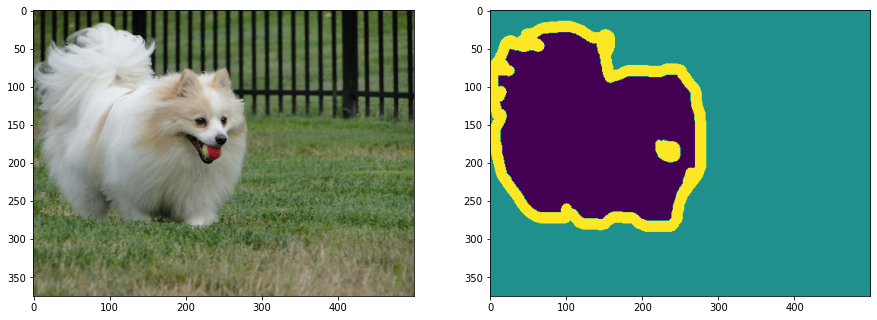

In [ ]:
image_files = glob('/content/drive/MyDrive/oxford_pet/images/*.jpg')
image_path = image_files[134]
seg_path = image_path.replace('images','annotations/trimaps')
seg_path = seg_path.replace('jpg','png')

image = cv2.imread(image_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
seg_map = cv2.imread(seg_path,cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(image) 
plt.subplot(122)
plt.imshow(seg_map)
plt.show()

개랑 고양이에 해당하는 값은 1, 배경은 0 그 중 어디에도 속하지 않은 값은 2 => 세 가지 값

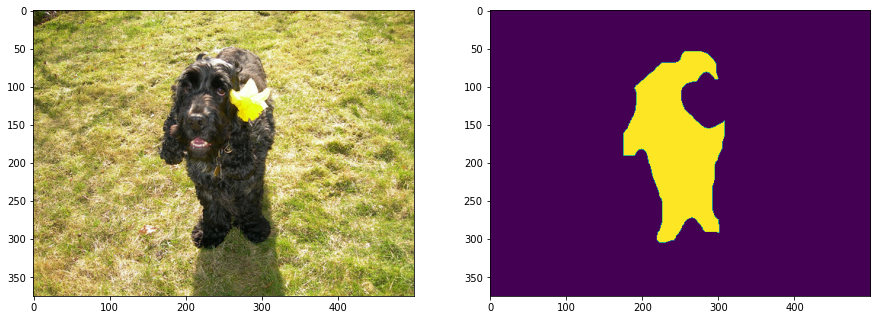

In [ ]:
seg_map[seg_map != 1] = 0

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(image) 
plt.subplot(122)
plt.imshow(seg_map)
plt.show()

## IoU/Jaccard Index/Dice coefficient

In [ ]:
'''
y_true = |0|1|1|0|
y_pred = |0.5|1|0.2|0.3|
y_true * y_pred = |0|1|0.2|0| => 1.2
'''

def iou(y_true,y_pred):
    smooth = 0

    # Flatten
    y_true = tf.reshape(y_true,[-1])
    y_pred = tf.reshape(y_pred,[-1])

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection

    score = intersection/(union+smooth)  
    return score

def dice_coef(y_true,y_pred):
    smooth = 0

    # Flatten
    y_true = tf.reshape(y_true,[-1])
    y_pred = tf.reshape(y_pred,[-1])

    intersection = tf.reduce_sum(y_true*y_pred)
    score = (2 * intersection)/(tf.reduce_sum(y_true)+tf.reduce_sum(y_pred)+smooth)
    return score

def dice_loss(y_true,y_pred):
    loss = 1 - dice_coef(y_true,y_pred)
    return loss

def bce_dice_loss(y_true,y_pred):
    loss = 1 * losses.binary_crossentropy(y_true,y_pred) + 1 * dice_loss(y_true,y_pred) # 경우에 따라서 비율을 다르게 할 수도 있음

    return loss


In [ ]:
print(dice_coef(seg_map.astype('float32'),seg_map.astype('float32')).numpy())
print(iou(seg_map.astype('float32'),seg_map.astype('float32')).numpy())

1.0
1.0


In [ ]:
zeros = np.zeros_like(seg_map)
print(dice_coef(seg_map.astype('float32'),zeros.astype('float32')).numpy())
print(iou(seg_map.astype('float32'),zeros.astype('float32')).numpy())

0.0
0.0


In [ ]:
ones = np.ones_like(seg_map)
print(dice_coef(seg_map.astype('float32'),ones.astype('float32')).numpy())
print(iou(seg_map.astype('float32'),ones.astype('float32')).numpy())

0.18365873
0.10111467


# DataLoader

In [ ]:
import math
import random

import pandas as pd

img_path: /content/drive/MyDrive/oxford_pet/images/Abyssinian_100.jpg
mask_path: /content/drive/MyDrive/oxford_pet/annotations/trimaps/Abyssinian_100.png
(500, 394)


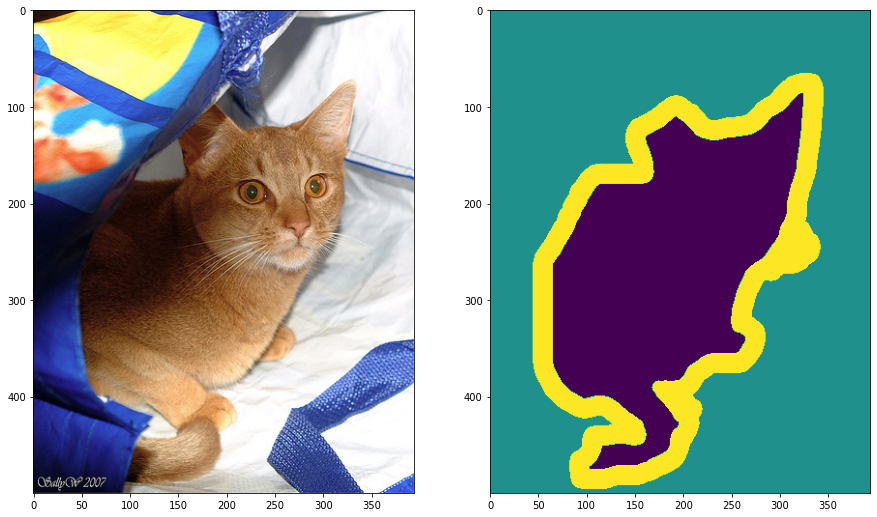

In [ ]:
img_path = f'/content/drive/MyDrive/oxford_pet/images/Abyssinian_100.jpg'
mask_path = f'/content/drive/MyDrive/oxford_pet/annotations/trimaps/Abyssinian_100.png'

print('img_path:',img_path)
print('mask_path:',mask_path)

img = cv2.imread(img_path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
print(mask.shape)

assert img.shape[:2] == mask.shape[:2]

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(mask)
plt.show()

In [ ]:
mask

array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]], dtype=uint8)

In [ ]:
from tensorflow import keras
import albumentations as A
import cv2

class Augmentation:
    def __init__(self, size, mode='train'):
        if mode == 'train':
            # Declare an augmentation pipeline
            self.transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.ShiftScaleRotate(
                    p=0.5,
                    shift_limit=0.05,
                    scale_limit=0.05,
                    rotate_limit=15,
                ),
                A.CoarseDropout(
                    p=0.5,
                    max_holes=8,
                    max_height=int(0.1 * size),
                    max_width=int(0.1 * size)
                ),
                A.RandomBrightnessContrast(p=0.2),
            ])
    def __call__(self, **kwargs):
        if self.transform:
            augmented = self.transform(**kwargs)
            img = augmented['image']
            mask = augmented['mask']
            return img, mask
        
class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, csv_path, image_size,
                 fold, mode='train', shuffle=True):
        self.fold = fold
        self.shuffle = shuffle
        self.mode = mode
        self.batch_size = batch_size
        self.image_size = image_size
        
        self.df = pd.read_csv(csv_path)
        if self.mode == 'train':    
            self.df = self.df[self.df['fold'] != self.fold]
        elif self.mode == 'val':
            self.df = self.df[self.df['fold'] == self.fold]
        
        #### Remove invalid files
        #### https://github.com/tensorflow/models/issues/3134
        invalid_filenames = [
            'Egyptian_Mau_14',
            'Egyptian_Mau_139',
            'Egyptian_Mau_145',
            'Egyptian_Mau_156',
            'Egyptian_Mau_167',
            'Egyptian_Mau_177',
            'Egyptian_Mau_186',
            'Egyptian_Mau_191',
            'Abyssinian_5',
            'Abyssinian_34',
            'chihuahua_121',
            'beagle_116'
        ]
        self.df = self.df[~self.df['file_name'].isin(invalid_filenames)]
        self.transform = Augmentation(image_size, mode)
        
        self.on_epoch_end()
            
    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)
    
    def __getitem__(self, idx):
        strt = idx * self.batch_size
        fin = (idx + 1) * self.batch_size
        data = self.df.iloc[strt:fin]
        
        batch_x, batch_y = self.get_data(data)

        return np.array(batch_x), np.array(batch_y)
        
    def get_data(self, data):
        batch_x = []
        batch_y = []
    
        for _, r in data.iterrows():
            file_name = r['file_name']

            image = cv2.imread(f'/content/drive/MyDrive/oxford_pet/images/{file_name}.jpg')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (self.image_size, self.image_size))
            
            mask = cv2.imread(f'/content/drive/MyDrive/oxford_pet/annotations/trimaps/{file_name}.png',
                              cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (self.image_size, self.image_size))
            mask[mask != 1] = 0
            
            if self.mode == 'train':
                #image = image.astype('uint8')
                image, mask = self.transform(image=image, mask=mask)
                
            image = image.astype('float32')
            image = image / 255.
            mask = mask.astype('float32')

            batch_x.append(image)
            batch_y.append(mask)
        
        return batch_x, batch_y
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

In [ ]:
csv_path = '/content/drive/MyDrive/FastCampus/ImageSegmentation/kfolds.csv'
train_generator = DataGenerator(
    fold=1,
    mode='train', 
    csv_path = csv_path,
    batch_size=128,
    image_size=256,
    shuffle=True
)

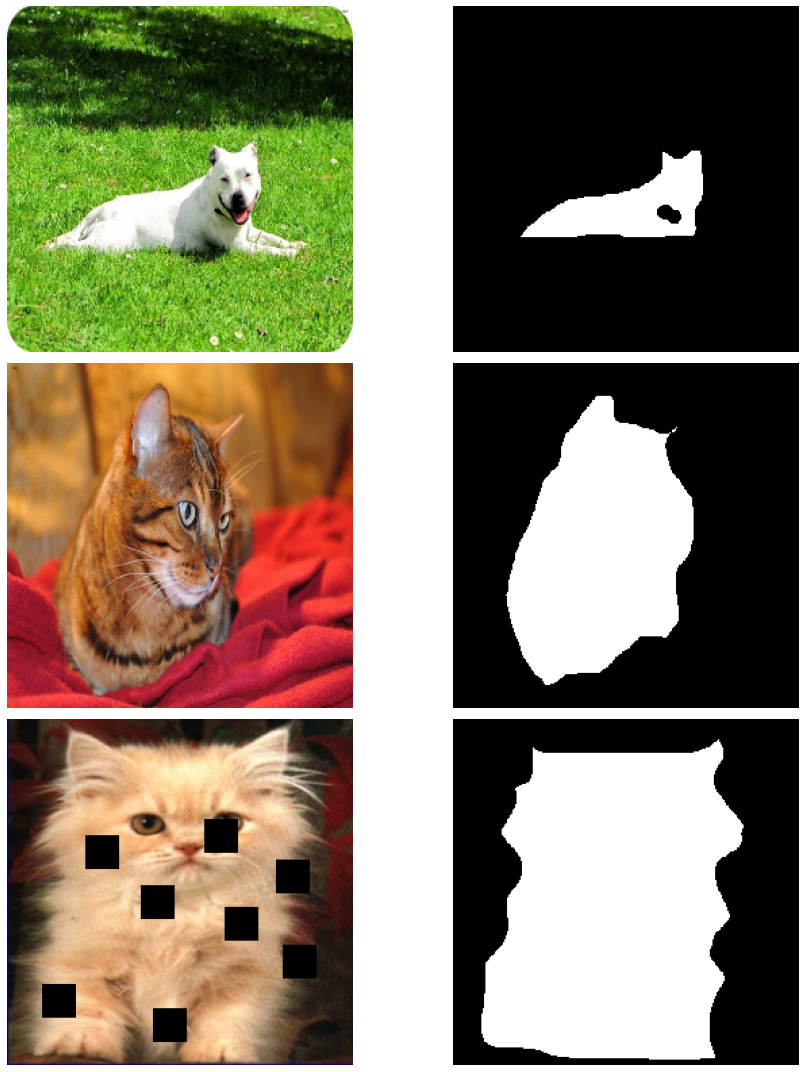

In [ ]:
for batch in train_generator:
    X,y = batch 
    plt.figure(figsize=(15,15))

    for i in range(3):
        plt.subplot(3,2,i*2+1)
        plt.imshow(X[i])
        plt.axis('off')
        plt.subplot(3,2,i*2+2)
        plt.imshow(y[i],cmap='gray')   
        plt.axis('off') 
        plt.tight_layout()
    break

# Training with UNet

In [ ]:
csv_path = '/content/drive/MyDrive/FastCampus/ImageSegmentation/kfolds.csv'
train_generator = DataGenerator(
    fold=1,
    mode='train',
    csv_path=csv_path,
    batch_size=128,
    image_size=128,
    shuffle=True)

valid_generator = DataGenerator(
    fold=1,
    mode='val',
    csv_path=csv_path,
    batch_size=128,
    image_size=128,
    shuffle=True)

In [ ]:
!pip install keras_unet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from keras_unet.models import custom_unet

model = custom_unet(
    input_shape = (128,128,3),
    use_batch_norm = True,
    upsample_mode = 'deconv',
    dropout_type = 'spatial',
    use_attention=True,
    num_classes=1,
    filters=64,
    dropout=0.2,
    num_layers=4,
    output_activation='sigmoid')

model.compile(optimizer='adam',loss=bce_dice_loss,metrics=[iou])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_93 (Conv2D)             (None, 128, 128, 64  1728        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_54 (BatchN  (None, 128, 128, 64  256        ['conv2d_93[0][0]']              
 ormalization)                  )                                                           

In [ ]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    verbose=1
)

Epoch 1/10


ResourceExhaustedError: ignored